<b>Проект для «Викишоп» на BERT</b>

<b>Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.</b>

В этом проекте я планирую загрузить и изучить данные, содержащие комментарии, которые уже имеют разметку о токсичности, и на их основе обучить несколько моделей для поиска в будущем токсичных комментариев. Наилучшую модель я проверю на тестовой выборке. Целью проекта является подбор такой модели и таких параметров, чтобы метрика F1 обученной модели была не менее 0,75.

### 1. Изучение и подготовка данных

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import codecs
from numba import cuda
import numpy as np 
import math
from random import shuffle
from keras_bert import load_trained_model_from_checkpoint
import tensorflow as tf
#import tokenization
import torch
import transformers
from pymystem3 import Mystem
from tqdm import tqdm
from tqdm import notebook
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import random
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
pth1 = 'D:\\Documents\\Downloads\\toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

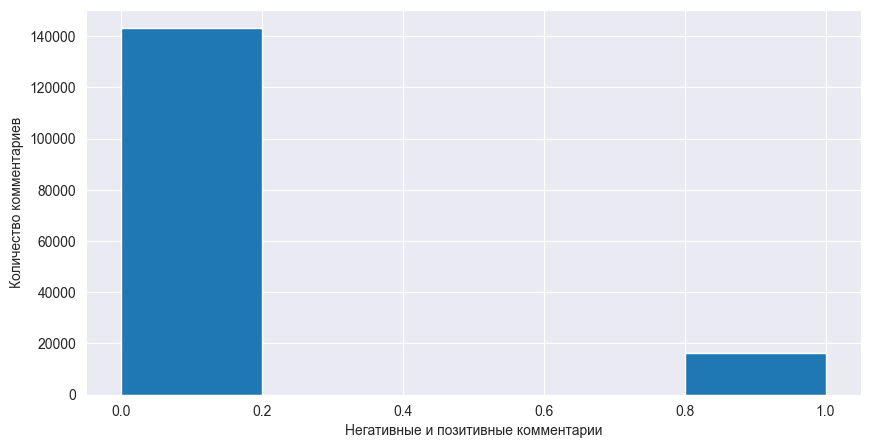

In [8]:
sns.set_style('darkgrid')
df['toxic'].hist(bins=5,figsize=(10,5))
plt.xlabel('Негативные и позитивные комментарии')
plt.ylabel('Количество комментариев');

Позитивных комментариев почти в 9 раз меньше, чем негативных.

In [9]:
corpus = list(df['text'])

In [10]:
def clear_text(text):
    y=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k=" ".join(y.split())
    return k

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
def lemmafunction(text):
    lemmatizer = WordNetLemmatizer()
    x=[]
    for i in nltk.word_tokenize(text):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        x.append(y)
    return " ".join(x)

In [13]:
lemy=[]
for i in tqdm(range(len(corpus))):
    lemy.append(lemmafunction(clear_text(corpus[i])))
df['lemm_text']=pd.Series(lemy, index=df.index)

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [1:09:53<00:00, 37.99it/s]


In [14]:
df.head()

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww He match this background colour I 'm see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I 'm really not try to edit war It 's ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n't make any real suggestion on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


In [16]:
df['lemm_text'].shape

(159292,)

In [18]:
ind_20 = random.sample(list(df.index), 20000)
df_lemm = df[df.index.isin(ind_20)].reset_index(drop=True)
df_lemm.shape

(20000, 4)

In [19]:
voc1 = 'D:\\Степанова\\bert-base-uncased-vocab.txt'
voc2 = '/datasets/bert-base-uncased-vocab.txt'

if os.path.exists(voc1):
    tokenizer = transformers.BertTokenizer(vocab_file=(voc1))
elif os.path.exists(voc2):
    tokenizer = transformers.BertTokenizer(vocab_file=(voc2))
else:
    print('Something is wrong')

In [20]:
%%time
tokenized = df_lemm['lemm_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, truncation=True, max_length=100))

CPU times: total: 34.2 s
Wall time: 34.3 s


In [21]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [22]:
%%time
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

CPU times: total: 188 ms
Wall time: 200 ms


In [23]:
attention_mask = np.where(padded != 0, 1, 0)

In [24]:
con1 = 'D:\\Степанова\\bert-base-uncased-config.json'
con2 = '/datasets/bert-base-uncased-config.json'

if os.path.exists(con1):
    config = transformers.BertConfig.from_json_file(con1)
elif os.path.exists(con2):
    config = transformers.BertConfig.from_json_file(con2)
else:
    print('Something is wrong')

mod1 = 'D:\\Степанова\\bert-base-uncased-pytorch_model.bin'
mod2 = '/datasets/bert-base-uncased-pytorch_model.bin'

if os.path.exists(mod1):
    model = transformers.BertModel.from_pretrained(mod1, config=config)
elif os.path.exists(mod2):
    model = transformers.BertModel.from_pretrained(mod2, config=config)
else:
    print('Something is wrong')

    
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

Some weights of the model checkpoint at D:\Степанова\bert-base-uncased-pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/200 [00:00<?, ?it/s]

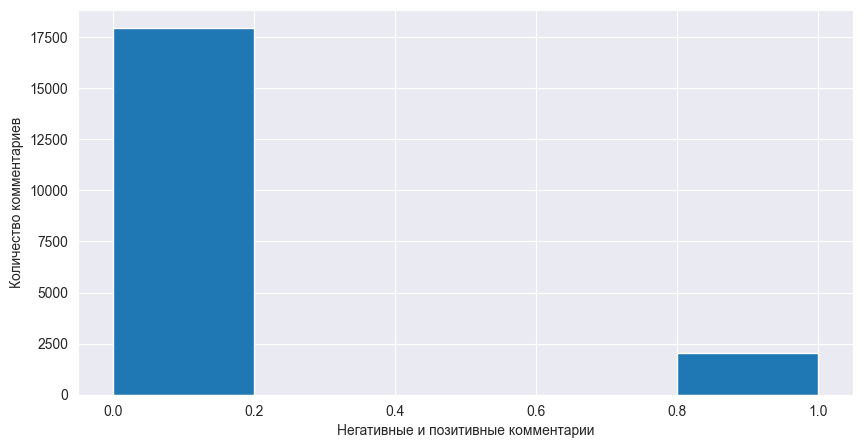

In [25]:
sns.set_style('darkgrid')
df_lemm['toxic'].hist(bins=5,figsize=(10,5))
plt.xlabel('Негативные и позитивные комментарии')
plt.ylabel('Количество комментариев');

In [26]:
df_lemm['toxic'].value_counts()

0    17943
1     2057
Name: toxic, dtype: int64

После уменьшения данных соотношение между позитивными и токсичными комментариями сохранилось. Это значит, что нужно сбалансировать классы для лучшего обучения моделей.

In [27]:
x = np.concatenate(embeddings)
y = df_lemm['toxic']

In [28]:
x_study, x_test, y_study, y_test = train_test_split(x, y, test_size=0.2, random_state=12345)

x_train, x_valid, y_train, y_valid = train_test_split(x_study, y_study, test_size=0.25, random_state=12345)

### 2. Обучение моделей

<b>Обучение модели Логистическая регрессия</b>

In [33]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)
#predict_lr=model_lr.predict(x_valid) 
#f1_lr = f1_score(y_valid, predict_lr)
scores = cross_val_score(model_lr, x_valid, y_valid, cv=5, scoring='f1_macro')
f1_lr = scores.mean()
print('Метрика F1 качества предсказания модели "LogisticRegression" равна :',f1_lr.round(2))

Метрика F1 качества предсказания модели "LogisticRegression" равна : 0.7818744243907401


<b>Обучение модели Решающее дерево</b>

In [34]:
%%time
best_model_tree = None
best_result_tree = 0
best_depth_tree=0
for depth in tqdm(range(2, 50, 2)):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
    model_tree.fit(x_train, y_train) 
    scores = cross_val_score(model_tree, x_valid, y_valid, cv=5, scoring='f1_macro')
    result_tree = scores.mean()
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
          
        best_depth_tree = depth
print('F1 наилучшей модели равно:', best_result_tree.round(2))
print('C глубиной:',best_depth_tree)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [07:33<00:00, 18.91s/it]

F1 наилучшей модели равно: 0.66 C глубиной: 14
CPU times: total: 7min 30s
Wall time: 7min 33s


<b>Обучение модели Случайный лес</b>

In [35]:
%%time
best_model_rf = None
best_result_rf = 0
best_est_rf=0
best_depth_rf = 0
for est in tqdm(range(20, 200, 20)):
    for depth in range (2, 20, 2): 
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced_subsample') 
        model_rf.fit(x_train, y_train) 
        scores = cross_val_score(model_rf, x_valid, y_valid, cv=5, scoring='f1_macro')
        result_rf = scores.mean()
        if result_rf > best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result_rf
            best_depth_rf = depth
            best_est_rf = est
print('F1 наилучшей модели равно:', best_result_rf.round(2))
print('C количеством деревьев:',best_est_rf)
print('C глубиной:',best_depth_rf)

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:34:43<00:00, 299.14s/it]

F1 наилучшей модели равно: 0.76
C количеством деревьев: 140
C глубиной: 4
CPU times: total: 1h 34min 33s
Wall time: 1h 34min 43s


### 3. Выводы

In [37]:
comparison = pd.DataFrame({
    'Модели': ['Логистическая регрессия', 'Решающее дерево', 'Случайный лес'],
    'Метрика F1': [f1_lr.round(2), best_result_tree.round(2), best_result_rf.round(2)]}
)
comparison    

,Модели,Метрика F1
0,Логистическая регрессия,0.78
1,Решающее дерево,0.66
2,Случайный лес,0.76


Логистическая регрессия и модель Слйчайный лес показали результаты метрики F1 более 0,75, что требовалось по заданию проекта. Но наилучший результат показала модель Логистическая Регрессия - 0,78, теперь нужно протестировать ее на тестовой выборке.

In [38]:
f1_lr_test = cross_val_score(model_lr, x_test, y_test, cv=5, scoring='f1_macro').mean()
f1_lr_test.round(2)

0.82

<b>ВЫВОД:
    
<b>Модель Логистической регрессии на тестовой выборке тоже показала результат высше 0,82, поэтому могу ее рекомендовать Интернет-магазину «Викишоп» для поиска токсичных комментариев для дальнейшего отправления их на модерацию.